# The Hawaii Cesspool Hazard Assessment & Prioritization Tool:
# Molokai Version 3


## ................................................ Code Notebook ................................................
*September 2024*

**Prepared For:** 
NOAA Coastal Zone Management Progam

**Principal Investigator and Primary Software Developer** 
- Christopher Shuler Ph.D., Shuler Hydrologic LLC


### Highlights for Version 3
- Updated using existing methodology to include the island of Molokai
- Using a digital ocean space cloud storage bucket to reference large files for the code, so as not to keep them in the repo


### Methods: Input datasets

#### Physical drivers and risk factors
- These are factors that physically control the transport, attenuation, or otherwise affect the level of impact an OSDS at a given location will have on the environment and water quality

- The impact of an individual OSDS depends on an array of factors regarding the substrate within which it is installed, its location and proximity to sensitive areas, the ultimate discharge point of its effluent and the conservative constituents therein, and the cumulative impacts of other nearby OSDS, which together may more quickly overwhelm the adsorption and contaminant attenuation capacity of the subsurface than an individual system would. 
- We considered all numerically or categorically quantifiable factors relating to variability in OSDS impacts, for which we were able to find statewide datasets, we call these "Risk Factors". 
- While some of the risk factor datasets had missing values we generally only included datasets for which we had a minimum of 90% coverage of the OSDS in the state. 
- For each risk factor we defined a scaler relationship or score between the variable and the spatial location of every individual OSDS unit which was then weighted, and averaged with the scores of all other risk factors to produce a single final prioritization ranking 
- for each individual OSDS in our state-wide inventory, we calculated a numeric value based on the relationship between the location of the OSDS unit and the spatial distribution of the risk factor so that every OSDS unit is assigned a score for every risk factor. 


#### Value- based risk factors
While the physical factors control the level of impact, we have also included value-based factors that quantify the spatial distribution of human and environmental value within the areas calculated to be affected by the discharge of cesspool effluent through the use of groundwater flow modeling.

In [7]:
# load up dependencies and local functions
%run functions.py
from IPython.display import Image

# relative paths
homedir = os.getcwd()
if not os.path.exists(os.path.join(homedir,'tempspace')): os.makedirs(os.path.join(homedir,'tempspace'))  
tempspace = os.path.join(homedir, "tempspace")
if not os.path.exists(os.path.join(".", 'Outputs/intermidiate_DataFrames')): os.makedirs(os.path.join(".", 'Outputs/intermidiate_DataFrames'))  
intermidiate_DataFramesPath = os.path.join(".", 'Outputs/intermidiate_DataFrames')

pd.set_option('display.max_rows', 10)

In [14]:
# To save time, load dataframes from the pre-run analysis
for i in os.listdir(intermidiate_DataFramesPath):
    name = i.split(".")[0]
    tempframe = pd.read_csv(os.path.join(intermidiate_DataFramesPath, i), index_col=0)
    globals()[str(name)] = tempframe   # This is sly, use globals to define an in-memory variable 
#osds_path = os.path.join(tempspace, "OSDS_cleaned.shp")

# This takes the directory of CSV files from intermidiate_DataFramesPath, if the code has been run yet) to dynamically
# load each CSV into a separate global variable, where the variable name is based on the CSV file's name.
# In essence, it's automatically loading each CSV into memory as a DataFrame and naming the variables after the CSV file names.

## Import OSDS File 
##### This creates a clean OSDS file from which all other cells will pull 
Currently using OSDS_v6 which incorporates 2020 updates from the DoH Wastewater branch (v3) IWS Database (V4) as well as the 4 counties tax records dwelling databases (V5).  This can easily be substituted as updates to the OSDS inventory are created.  This version wa run specifically for Molokai based on the Molokai V5 OSDS dataset made for Nancy 

In [15]:
# Read in latest OSDS dataset  has to have an X and Y column in WGS 84

fromshp = os.path.join("..", "Projected_data/OSDS_v6_Exploded/", 'CESSPOOLSv6_Exploded.shp')
OSDS = Format_OSDS_shp(fromshp, cleanitup=True)

# Deal with Dupes
checkdup = OSDS.pivot_table(index=['Uid'], aggfunc='size')
#print(f"there are duplicate points at: {checkdup[checkdup != 1]}")
# remove the duplicates (keep first entry of the duplicate row)
OSDS.drop_duplicates(subset=['Uid'], keep="first", inplace=True)
# Reindex or else the future joins will be based on an index with dupes
OSDS.reset_index(drop=True, inplace=True)

# Save csv
OSDS.to_csv(os.path.join(intermidiate_DataFramesPath, "OSDS.csv"))

# Convert the now formatted OSDS csv back to a shapefile for the subsequent analyses
csvFilePath = os.path.join(intermidiate_DataFramesPath, "OSDS.csv")
convert_OSDS_csv_to_shp(csvFilePath)

# Define the cleaned up OSDS file all the other cells can use
osds_path = os.path.join(tempspace, "OSDS_cleaned.shp")
print("There are {} (OSDS or Cesspools) in this dataset".format(len(OSDS)))

There are 1280 (OSDS or Cesspools) in this dataset


## Distance to Municipal or domestic wells 


Average dist2_MunWells_m is 6136.877258811058
Max dist2_MunWells_m is 27573.79162605669
Min dist2_MunWells_m is 109.26694837034235


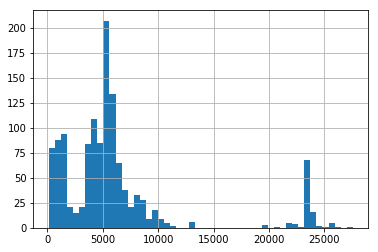

In [16]:
# Generate parameter info about the Municipal wells MODERATE RUN TIME
shp_path = os.path.join("..", "Projected_data/Wells", 'CWRM_Wells_MUN_prj.shp')
new_col_name = "dist2_MunWells_m"
# Run the near analysis 
MUN_WELLS = Calc_dist_to_variable(osds_path, shp_path, new_col_name)
MUN_WELLS.to_csv(os.path.join(intermidiate_DataFramesPath, "MUN_WELLS.csv"))
# plot histogram
Hist_and_stats_on_DF(MUN_WELLS, "dist2_MunWells_m")

Average dist2_DomWells_m is 11132.087318388018
Max dist2_DomWells_m is 36562.96007228427
Min dist2_DomWells_m is 32.432537633769925


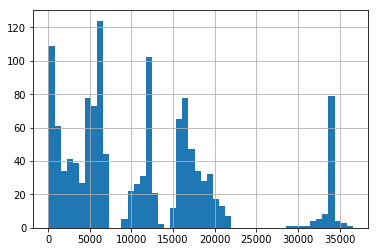

In [17]:
# Generate paramater info about the Domestic wells MODERATE RUN TIME
shp_path = os.path.join("..", "Projected_data/Wells", 'CWRM_Wells_DOM_prj.shp')
new_col_name = "dist2_DomWells_m"
# Run the near analysis 
DOM_WELLS = Calc_dist_to_variable(osds_path, shp_path, new_col_name)
DOM_WELLS.to_csv(os.path.join(intermidiate_DataFramesPath, "DOM_WELLS.csv"))
# plot histogram
Hist_and_stats_on_DF(DOM_WELLS, "dist2_DomWells_m")

## Well capture zones


In [20]:
In_polygons = os.path.join("..", "Projected_data/Well_CZs", 'ZoneB_Composite_Molokai.shp')
new_col_name = 'In_WellCZ_B'
In_points = osds_path

WellCZ_B_yes = Find_points_inside_polys(In_points, In_polygons, new_col_name)
WellCZ_B_yes.to_csv(os.path.join(intermidiate_DataFramesPath, "WellCZ_B_yes.csv"))

print_stats_on_bool_layers(WellCZ_B_yes)

number of affected points = 3
number of total systems = 1280
percent of systems affected = 0.00234375


In [21]:
In_polygons = os.path.join("..", "Projected_data/Well_CZs", 'ZoneC_Composite_Molokai.shp')
new_col_name = 'In_WellCZ_C'
In_points = osds_path

WellCZ_C_yes = Find_points_inside_polys(In_points, In_polygons, new_col_name)
WellCZ_C_yes.to_csv(os.path.join(intermidiate_DataFramesPath, "WellCZ_C_yes.csv"))

print_stats_on_bool_layers(WellCZ_C_yes)

number of affected points = 36
number of total systems = 1280
percent of systems affected = 0.028125


## Distance to streams


Average dist2_Streams_m is 269.36113061910834
Max dist2_Streams_m is 1148.203488529939
Min dist2_Streams_m is 0.175227375914354


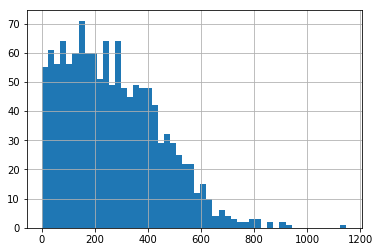

In [22]:
# Generate parameter info about the Municipal wells MODERATE RUN TIME
shp_path = os.path.join("..", "Projected_data/Streams", 'Streams_prj.shp')
new_col_name = "dist2_Streams_m"
# Run the near analysis 
STREAMS = Calc_dist_to_variable(osds_path, shp_path, new_col_name)
STREAMS.to_csv(os.path.join(intermidiate_DataFramesPath, "STREAMS.csv"))
# plot histogram
Hist_and_stats_on_DF(STREAMS, "dist2_Streams_m")

## Distance to Wetlands


Average dist2_Wetlands_m is 1665.5024292484202
Max dist2_Wetlands_m is 8630.798943424586
Min dist2_Wetlands_m is 11.248930451902707


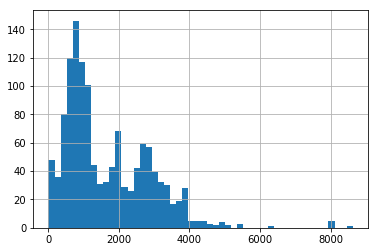

In [23]:
# Generate parameter info about the wetlands
shp_path = os.path.join("..", "Projected_data/Wetlands", 'Wetlands_emergent_ponds.shp')
new_col_name = "dist2_Wetlands_m"
# Run the near analysis 
WETLANDS = Calc_dist_to_variable(osds_path, shp_path, new_col_name)
WETLANDS.to_csv(os.path.join(intermidiate_DataFramesPath, "WETLANDS.csv"))
# plot histogram
Hist_and_stats_on_DF(WETLANDS, "dist2_Wetlands_m")

## Distance to the coastline


Average dist2_coast_m is 1015.4681208726258
Max dist2_coast_m is 5113.371334908346
Min dist2_coast_m is 2.692405061562155


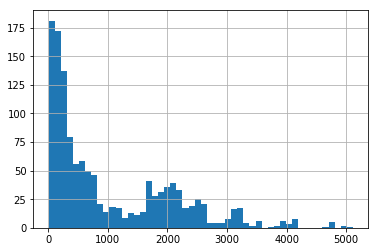

In [24]:
# Generate parameter info about the COASTLINE   looong RUN TIME 
shp_path = os.path.join("..", "Projected_data/Coastline", 'Coastline_line_prj.shp')
new_col_name = "dist2_coast_m"
# Run the near analysis 
COASTLINE = Calc_dist_to_variable(osds_path, shp_path, new_col_name)
COASTLINE.to_csv(os.path.join(intermidiate_DataFramesPath, "COASTLINE.csv"))
# plot histogram
Hist_and_stats_on_DF(COASTLINE, "dist2_coast_m")

## Extracting values from Rainfall raster 


Average rainfall_in is 27.45175240486723
Max rainfall_in is 101.38800048799999
Min rainfall_in is 9.66359329224


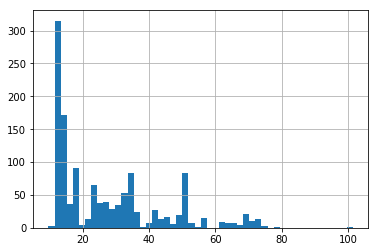

In [25]:
In_raster = os.path.join("..", "Projected_data/Rain", 'Rain_inann.tif')
In_points = osds_path
new_col_name = "rainfall_in"

RAINFALL = extract_values_from_rasters(In_raster, In_points, new_col_name, tempspace)
RAINFALL.to_csv(os.path.join(intermidiate_DataFramesPath, "RAINFALL.csv"))
# plot histogram
Hist_and_stats_on_DF(RAINFALL, "rainfall_in")

## Soils 


In [26]:
# Pull in soils data from NRCS
In_polygons = os.path.join("..", "Projected_data/Soils", 'HIstate_nrcs_join2.shp')
new_col_name = 'Soil_Ksat_2ndry'
In_points = osds_path

# Columns you want from the shapefile (Uid should always  be first one) 
want_cols = ['Uid', 'brockdepmin', 'flodfreqdcd', 'engstafdcd', 'engstafll', 
             'engstafml', 'cokey', 'ksat_h', 'ksat_l', 'ksat_r', 'sieveno10_r', ]  # 'totalsub_r', slopegradw

renames = {'brockdepmi':'nrcs_DtoBrock', 
 'flodfreqdc':'nrcs_FloodFreq',
 'engstafdcd':'nrcs_septic_dominant', 
 'engstafll':'nrcs_septic_least', 
 'engstafml':'nrcs_septic_most', 
 'ksat_h':'nrcs_ksat_hi',  
 'ksat_l':'nrcs_ksat_lo',
 'ksat_r':'nrcs_ksat_rep', 
 'sieveno10_':'nrcs_rockFrag3in'}    # 'slopegradw':'nrcs_slope', 'totalsub_r':'nrcs_subsidence'

# Do the spatial join
arcpy.SpatialJoin_analysis(In_points, In_polygons, os.path.join(tempspace, "test_join_pt_2_poly.shp"))

# read data from shapefile 
extracted_points_path = os.path.join(tempspace, "test_join_pt_2_poly.shp")
arcpy.TableToTable_conversion(extracted_points_path, tempspace, 'extracted_all.csv') # Create a rational file format
# Create a rational PanDataframe
Extracted_All = pd.read_csv(os.path.join(tempspace, 'extracted_all.csv'))

want_cols = ['Uid', 'brockdepmi', 'flodfreqdc', 'engstafdcd', 'engstafll', 
             'engstafml', 'ksat_h', 'ksat_l', 'ksat_r', 'sieveno10_'] # 'slopegradw' , 'totalsub_r'
Extract_frame = Extracted_All[want_cols]

Extract_frame = Extract_frame.replace('NoData', np.nan)  # clean up from arc's trashiness

numcols = ['brockdepmi', 'ksat_h', 'ksat_l', 'ksat_r', 'sieveno10_' ]  #'slopegradw',  'totalsub_r'
Extract_frame[numcols] = Extract_frame[numcols].apply(pd.to_numeric, errors='coerce', axis=1)

Extract_frame.rename(columns=renames, inplace=True)     # Rename to col that you want

SOILS_NRCS = Extract_frame.copy()


#### Filling in missing NRCS flood frequency data with rainfall and ksat
SOILS_NRCS = SOILS_NRCS.merge(RAINFALL, on="Uid", how='left')

# Set frequents 
SOILS_NRCS['nrcs_FloodFreq'][(SOILS_NRCS['nrcs_FloodFreq'].isnull()) & (SOILS_NRCS['nrcs_ksat_rep'] < 1.1) & (SOILS_NRCS['rainfall_in'] > 135)]  = "Frequent"    # "Frequent"      
SOILS_NRCS['nrcs_FloodFreq'][(SOILS_NRCS['nrcs_FloodFreq'].isnull()) & (SOILS_NRCS['nrcs_ksat_rep'] < 1.1) & (SOILS_NRCS['rainfall_in'] < 15)]  = "Frequent"    # "Frequent"      

# Set Occasionals 
SOILS_NRCS['nrcs_FloodFreq'][(SOILS_NRCS['nrcs_FloodFreq'].isnull()) & (SOILS_NRCS['rainfall_in'] > 135)]  = "Occasional"    # "Occasional"      
SOILS_NRCS['nrcs_FloodFreq'][(SOILS_NRCS['nrcs_FloodFreq'].isnull()) & (SOILS_NRCS['nrcs_ksat_rep'] < 1.1)]  = "Occasional"    # "Occasional"      

# set rest to none
SOILS_NRCS['nrcs_FloodFreq'][(SOILS_NRCS['nrcs_FloodFreq'].isnull())]  = "None"    # "None"      

del SOILS_NRCS['rainfall_in']

SOILS_NRCS.to_csv(os.path.join(intermidiate_DataFramesPath, "SOILS_NRCS.csv"))

## Slope


Average slope_deg is 3.875517410423101
Max slope_deg is 45.6593894958
Min slope_deg is 0.0


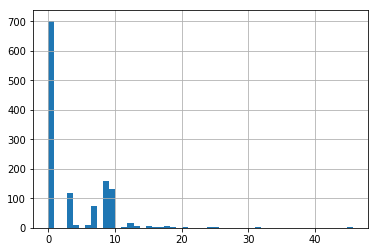

In [28]:
blankframe = pd.DataFrame(columns=["Uid"])

indir = os.path.join("..", "Projected_data\\DEMs\\Slope_WGS")  # Using a loop to go over different rasters from different islands
for idx, file in enumerate(os.listdir(indir)):
    if file.endswith(".tif"):
        In_raster = os.path.join(indir, file)
        In_points = osds_path
        new_col_name = "slope_{}".format(idx)       
        foo = extract_values_from_rasters(In_raster, In_points, new_col_name, tempspace)
        blankframe = blankframe.merge(foo, how='outer', on='Uid')

blankframe.set_index("Uid", inplace=True)
blankframe['slope_deg'] = blankframe.max(axis=1)  
blankframe.reset_index(inplace=True)

SLOPE = blankframe[["Uid", 'slope_deg']]
SLOPE.to_csv(os.path.join(intermidiate_DataFramesPath, "SLOPE.csv"))
# plot histogram
Hist_and_stats_on_DF(SLOPE, "slope_deg")